Source: https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb 

# Downloading data

In [1]:
# see install.md to get this working
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# PyPortfolioOpt
from pypfopt import risk_models, expected_returns
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

from xgb import Trainer

In [2]:
ETFs = ["SPY", "BND", "GLD", "HODL.PA"]
ohlc = yf.download(ETFs, period="15y")  # Open, High, Low, Close
closing_prices = ohlc["Close"]
closing_prices.tail()

# Shows closing prices for the ETFs the last 5 days.


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker,BND,GLD,HODL.PA,SPY
Date,,,,
2025-04-22,72.379997,311.109985,13.4124,527.250000
2025-04-23,72.529999,303.649994,13.7177,535.419983
2025-04-24,72.940002,308.070007,13.8389,546.690002
2025-04-25,73.180000,304.730011,14.1237,550.640015
2025-04-28,73.385002,308.799988,13.8488,550.109985


In [3]:
# Get closing prices, and show 5 latest ones. 
stock_prices = yf.download("SPY", period="15y")["Close"].dropna()
stock_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2010-04-28,90.719162
2010-04-29,91.843857
2010-04-30,90.285995
2010-05-03,91.456268
2010-05-04,89.305717


In [4]:
gold_prices = yf.download("GLD", period="15y")["Close"].dropna()
gold_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,GLD
Date,
2010-04-28,114.309998
2010-04-29,114.279999
2010-04-30,115.360001
2010-05-03,115.730003
2010-05-04,114.870003


In [5]:
bond_prices = yf.download("BND", period="15y")["Close"].dropna()
bond_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,BND
Date,
2010-04-28,51.789410
2010-04-29,51.808907
2010-04-30,51.958664
2010-05-03,51.930595
2010-05-04,52.080807


In [6]:
crypto_prices = yf.download("HODL.PA", period="15y")["Close"].dropna()
crypto_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,HODL.PA
Date,
2022-01-25,11.14
2022-01-26,11.14
2022-01-27,11.14
2022-01-28,11.14
2022-01-31,11.14


In [7]:
# Only fetches market caps for SPY and GLD

# mcaps = {}
# for t in ETFs:
#     try:
#         mcaps[t] = yf.Ticker(t).info["marketCap"]
#     except KeyError:
#         print(f"Inget market cap för {t}")
# mcaps

# Using hardcoded values instead:
mcaps = {
    "SPY": 481_714_784_600,     # manuellt från https://www.nasdaq.com/market-activity/etf/spy
    "BND": 122_936_437_056,     # manuellt från https://www.nasdaq.com/market-activity/etf/bnd
    "GLD": 77_500_318_000,      # manuellt från https://www.nasdaq.com/market-activity/etf/gld
    "HODL.PA": 1_200_295_500   #change to .PA     # manuellt från https://www.nasdaq.com/market-activity/etf/hodl
}
mcaps

{'SPY': 481714784600,
 'BND': 122936437056,
 'GLD': 77500318000,
 'HODL.PA': 1200295500}

# Constructing the prior

In [8]:
# Covariance matrix between all assets
cov_matrix = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
cov_matrix

Ticker,BND,GLD,HODL.PA,SPY
Ticker,,,,
BND,0.003627,0.002141,-0.000172,0.000071
GLD,0.002141,0.024182,0.001074,0.001278
HODL.PA,-0.000172,0.001074,0.070056,0.004528
SPY,0.000071,0.001278,0.004528,0.030300


In [9]:
# Risk aversion
delta = black_litterman.market_implied_risk_aversion(stock_prices)
print(delta)

4.440360528956184


<Axes: >

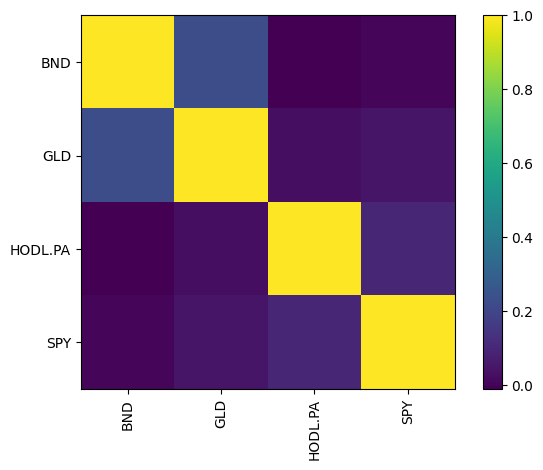

In [10]:
plotting.plot_covariance(cov_matrix, plot_correlation=True)

In [11]:
# Prior implied returns (Pi), N×1 column vector
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)
market_prior

Ticker
BND        0.004197
GLD        0.017897
HODL.PA    0.015123
SPY        0.095579
dtype: float64

<Axes: ylabel='Ticker'>

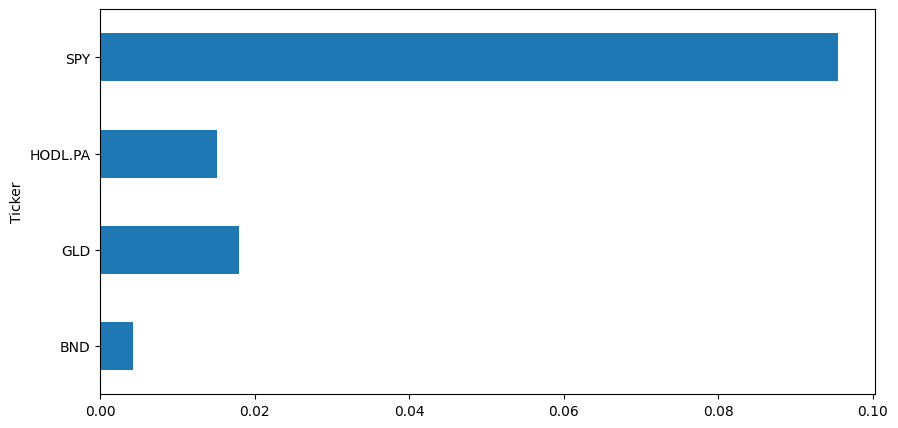

In [12]:
market_prior.plot.barh(figsize=(10,5))

# Views
Q contains the magnitude of each view, while P maps the views to the assets they belong to.

In [13]:
# # Absolute views, this should be coming from XGBoost, placeholder values atm
# viewdict = {
#     "SPY": 0.08,      # t.ex. +8% förväntad avkastning
#     "BND": 0.03,      
#     "GLD": 0.01,      
#     "HODL": 0.20,
# }

# View confidence
Using Idzorek's method
 - Maybe we can use some error term to evaluate the confidence levels?

In [14]:
# # Placeholder values:
# confidences = [0.6, 0.5, 0.3, 0.7]

In [15]:
# # Using idzorek method (specifying our own confidence levels)
# # You can also create omega yourself by creating a diagonal matrix based on the views variances
# bl_idzorek = BlackLittermanModel(cov_matrix, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [16]:
# # Posterior estimate of returns
# ret_bl = bl_idzorek.bl_returns()
# ret_bl

In [17]:
# # Visualization how this compares to the prior and our views:
# rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
#              index=["Prior", "Posterior", "Views"]).T
# rets_df

In [18]:
# rets_df.plot.bar(figsize=(12,8))
# # "Notice that the posterior is often between the prior and the views. 
# # This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views,
# # where the weight is determined by the confidence."

In [19]:
# # Posterior covariance estimate:
# cov_bl = bl_idzorek.bl_cov()
# plotting.plot_covariance(cov_bl)

# Portfolio allocation

In [20]:
# from pypfopt import EfficientFrontier, objective_functions

In [21]:
# ef = EfficientFrontier(ret_bl, cov_bl)
# #ef.add_objective(objective_functions.L2_reg)
# ef.max_sharpe() # to maximize sharpe ratio, can be changed
# weights = ef.clean_weights()
# weights

In [22]:
# pd.Series(weights).plot.pie(figsize=(10,10))

In [23]:
# # Example of how much to spend in each asset based on capital
# from pypfopt import DiscreteAllocation

# da = DiscreteAllocation(weights, closing_prices.iloc[-1], total_portfolio_value=10000)
# # alloc, leftover = da.lp_portfolio() funkar ej
# alloc, leftover = da.greedy_portfolio()
# print(f"Leftover: ${leftover:.2f}")
# alloc #antal andelar
df_crypto = pd.read_csv("merged2.csv", parse_dates=["Date"])

In [24]:
import pandas as pd
from xgb import Trainer

SCALE   = 1.0          # =1 om du vill använda size oförändrat
trainer = Trainer.load("models")     # joblib-filen du sparade

viewdict, confidences = {}, []

for ticker in ETFs:                         # ["SPY", "BND", "GLD", "HODL"]
    if ticker == "HODL.PA":
        # ── läs merged2.csv, sortera, ta sista 8 rader ──────────────
        df_crypto = (
            pd.read_csv("merged2.csv", parse_dates=["Date"])
              .sort_values("Date")
              .tail(8)
        )
        action, size, confidence = trainer.predict(df_crypto)
        viewdict[ticker]  = size * SCALE
        confidences.append(confidence)
    else:
        viewdict[ticker]  = 0.0        # neutral vy
        confidences.append(0.0)        # låg vikt

viewdict, confidences


({'SPY': 0.0, 'BND': 0.0, 'GLD': 0.0, 'HODL.PA': 0.12935605645179749},
 [0.0, 0.0, 0.0, 0.40313419699668884])

In [25]:

# Black‑Litterman with Idzorek confidences
bl_idzorek = BlackLittermanModel(
    cov_matrix,
    pi=market_prior,
    absolute_views=viewdict,
    omega="idzorek",
    view_confidences=confidences,
)

ret_bl = bl_idzorek.bl_returns()
cov_bl = bl_idzorek.bl_cov()

# Efficient frontier
ef = EfficientFrontier(ret_bl, cov_bl)
ef.max_sharpe()
weights = ef.clean_weights()
weights

#OrderedDict([('BND', 0.1263),
             #('GLD', 0.07962),
            # ('HODL', 0.29918),
            # ('SPY', 0.49489)])

OrderedDict([('BND', 0.15618),
             ('GLD', 0.09846),
             ('HODL.PA', 0.13339),
             ('SPY', 0.61198)])

<Axes: >

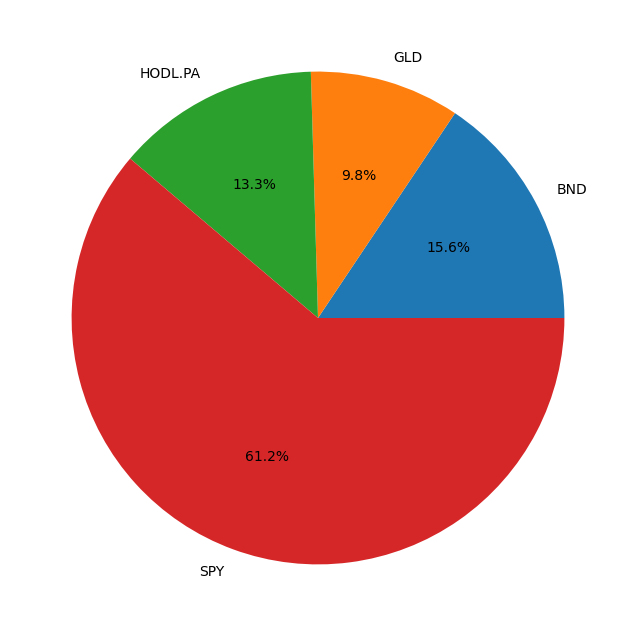

In [26]:

pd.Series(weights).plot.pie(figsize=(8,8), autopct='%1.1f%%')
